# Essai sur les premières frames

### 1. Récupération de la boîte englobante de début

In [2]:
import random as rd
import matplotlib.pyplot as plt
import cv2
import os

import utils.helpers.constants as path
from utils.helpers.data import * 
from utils.helpers.plot import * 
from utils.helpers.video import * 

In [ ]:
from importlib import reload
reload(path)

In [3]:
rdm_video_filename = rd.choice(os.listdir(path.__video_path__))
rdm_video_path = os.path.join(path.__video_path__, rdm_video_filename)

list_bbox_filename = rdm_video_filename.split('.')[0] +"_2_bboxes.txt"
list_bbox_path = os.path.join(path.__bboxes_path__,list_bbox_filename)

num_first_frame_with_coord  = get_num_first_frame_with_coord(list_bbox_path)
print(f"La première frame de la vidéo {rdm_video_filename} où l'objet apparait est la n°{num_first_frame_with_coord[0]}, les coordonnées de la boite sont :{num_first_frame_with_coord[1]} ")

La première frame de la vidéo RicePlace4Subject1.mp4 où l'objet apparait est la n°57, les coordonnées de la boite sont :(654, 390, 220, 340) 


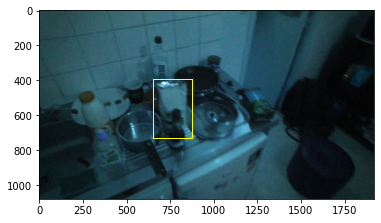

In [4]:
first_frame = get_frame_from_number(rdm_video_path, num_first_frame_with_coord[0])
plt.imshow(first_frame)
box_first_frame_coords = num_first_frame_with_coord[1]
plot_box(plt, rect=box_first_frame_coords, linewidth=1)

### 2. Récupération de la frame suivante et génération de boites aléatoires

plot 200


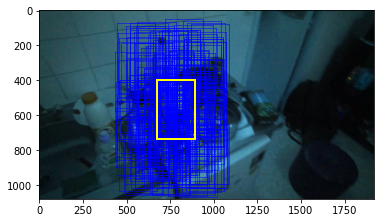

In [5]:
# On récupère la frame d'après
num_next_frame = num_first_frame_with_coord[0] + 1
next_frame = get_frame_from_number(rdm_video_path, num_next_frame)
rdm_boxes = generate_rdm_boxes_from_box(box_first_frame_coords,1,0,next_frame.shape[1],next_frame.shape[0],200)
all_true_boxes = get_all_true_box(list_bbox_path)

print('plot', len(rdm_boxes))
plt.imshow(next_frame)
for box in rdm_boxes:
    plot_box(plt, rect=box, linewidth=0.5, color="blue")
plot_box(plt, rect=all_true_boxes[num_next_frame])

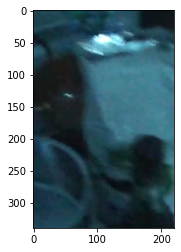

In [6]:
rdm_index = rd.randint(0,len(rdm_boxes)-1)
box = rdm_boxes[rdm_index]
img = next_frame[box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
plt.imshow(img)

# Tracking

In [7]:
import numpy as np
from keras import models
from copy import deepcopy
import cv2
import os, sys

import utils.helpers.constants as path
from utils.helpers.data import * 
from utils.helpers.plot import * 
from utils.helpers.video import * 

In [8]:
finalModel = models.load_model('models/vgg16_a__9.h5')

In [9]:
"""
Dans cette cellule les images apparaissent dans une autre fenêtre
il faut appuyer sur une touche du clavier pour passer à l'image suivante
"""
__batch_size__ = 32
class_labels, nb_labels = get_labels()
cv2.destroyAllWindows()

pred_boxes = []
num_first_frame, coords_first_box = get_num_first_frame_with_coord(list_bbox_path)
pred_boxes.append(coords_first_box)

cap = cv2.VideoCapture(rdm_video_path)
if not cap.isOpened():
    print("ERROR: unable to read video:", rdm_video_path)
    sys.exit()

label = rdm_video_filename.split("Place")[0]
label_id = class_labels.index(label)

i = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret == False:
        break

    if i > num_first_frame:
        newBoxes = generate_rdm_boxes_from_box(
            pred_boxes[-1],
            0.4,
            0.1,
            frame.shape[1],
            frame.shape[0],
            nb_box=__batch_size__,
        )

        batch_imgs = []
        img_to_show = deepcopy(frame)
        for j, box in enumerate(newBoxes):
            img = frame[box[1] : box[1] + box[3], box[0] : box[0] + box[2]]
            draw_box_in_matrix(img_to_show, box, linewidth=1)
            cv2.imshow("Detection", cv2.resize(img_to_show, (960, 540)))
            cv2.waitKey(1)
            
            batch_imgs.append(cv2.resize(img, dsize=(227, 227)))

        batch_imgs = np.array(batch_imgs)
        model_prediction_batch = finalModel.predict(batch_imgs)

        proba = [[pr[i] for pr in model_prediction_batch] for i in range(nb_labels)]

        bestBox = newBoxes[np.argmax(proba[label_id])]
        draw_box_in_matrix(img_to_show, bestBox, color=(0,0,255))
        cv2.imshow("Detection", cv2.resize(img_to_show, (960, 540)),)
        # print("\r",f"Frame: {i}", max(proba[label_id]), min(proba[label_id]), end="")
        key =  cv2.waitKey(10)
        while key == -1:
             key = cv2.waitKey(10)

        pred_boxes.append(bestBox)

    i += 1

    # for num_box,box in enumerate(newBoxes) :
    #     if ((len(batch_imgs) < __batch_size__) and num_box < len(newBoxes)) :
    #         # img = frame[box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
    #         img = frame[box[0]:box[0]+box[2],box[1]:box[1]+box[3]]
    #         print(img.shape)
    #         img_pre = preprocess_image(img)
    #         batch_imgs.append(img_pre)

    #     else:
    #         batch_imgs = np.array(batch_imgs)
    #         model_prediction_batch = finalModel.predict((batch_imgs))
    #         for pred in model_prediction_batch :
    #             proba.append(pred[label_id])
    #         batch_imgs = []


Rice 3 ['Bowl', 'CanOfCocaCola', 'MilkBottle', 'Rice', 'Sugar']


KeyboardInterrupt: 

In [10]:
cv2.destroyAllWindows()

-------------------

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# np.random.seed(19680801)
# data = np.random.random((50, 50, 50))

# fig, ax = plt.subplots()

# for i in range(len(data)):
#     ax.cla()
#     ax.imshow(data[i])
#     ax.set_title("frame {}".format(i))
#     # Note that using time.sleep does *not* work here!
#     plt.pause(0.1)

In [ ]:
frames_with_obj = [get_frame_from_number(rdm_video_path, i) for i in range(get_nb_frames_video(rdm_video_path)) if i >= num_first_frame]

In [ ]:
assert(len(frames_with_obj) == len(pred_boxes))

In [ ]:
import cv2
import os


for idx,frame_with_obj in enumerate(frames_with_obj) : 
    # frame = cv2.imread(frame_with_obj, 1)
    start_point= (pred_boxes[0],pred_boxes[1])
    end_point = (pred_boxes[0]+pred_boxes[2],pred_boxes[1]+pred_boxes[3])
    img_to_show = cv2.rectangle(frame_with_obj, start_point, end_point, (255,0,0), 2) 
    
    cv2.imshow('window', img_to_show)  

    key = cv2.waitKey(3000)#pauses for 3 seconds before fetching next image
    if key == 27:#if ESC is pressed, exit loop
        cv2.destroyAllWindows()
        break



# folder_path = __train_path__+'/Bowl'

# for path in os.listdir(folder_path):#loop to read one image at a time 
#     imgpath = os.path.join(folder_path, path)

#     frame = cv2.imread(imgpath, 1)

#     # start_point = (box_first_frame_coords[0], box_first_frame_coords[1])
#     # end_point = (box_first_frame_coords[0]+box_first_frame_coords[2], box_first_frame_coords[1]+box_first_frame_coords[3])
#     start_point= (10,10)
#     end_point = (15,15)
#     img_to_show = cv2.rectangle(frame, start_point, end_point, (255,0,0), 2) 
    
#     cv2.imshow('window', img_to_show)  

#     key = cv2.waitKey(3000)#pauses for 3 seconds before fetching next image
#     if key == 27:#if ESC is pressed, exit loop
#         cv2.destroyAllWindows()
#         break


In [ ]:
# # code de base : ne pas toucher
# pred_boxes = []
# num_first_frame, coords_first_box = get_num_first_frame_with_coord(list_bbox_path)
# pred_boxes.append(coords_first_box)

# cap = cv2.VideoCapture(rdm_video_path)
# if (not cap.isOpened()):
#     print("ERROR: unable to read video:", rdm_video_path)
#     sys.exit()

# label = rdm_video_filename.split('Place')[0]
# label_id = class_labels.index(label)

# i = 0
# while cap.isOpened():
#     ret, frame = cap.read()
#     if ret == False:
#         break
    
#     if i > num_first_frame:
#         newBoxes = generate_rdm_boxes_from_box(pred_boxes[-1], 50,50,frame.shape[1],frame.shape[0])
#         proba = []

#         for box in newBoxes:
#             img = frame[box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
#             img_pre = preprocess_image(img)
#             model_prediction = finalModel.predict((img_pre))
#             proba.append(model_prediction[label_id])
        
#         bestBox = newBoxes[np.argmax(proba)]
#         pred_boxes.append(bestBox)
    
#     i+=1